In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

2024-06-20 18:37:58.367410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 18:37:59.221322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the data
df = pd.read_csv('./task2_data/Steel_industry_data.csv')
df.head(1)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load


In [3]:
#Rename the columns for simplicity
df = df.rename(columns={'CO2(tCO2)': 'tco2',
                        'Lagging_Current_Reactive.Power_kVarh': 'lagging_kvarh',
                        'Leading_Current_Reactive_Power_kVarh': 'leading_kvarh',
                        'Lagging_Current_Power_Factor': 'lagging_pf',
                        'Leading_Current_Power_Factor': 'leading_pf'})

df.columns = df.columns.str.lower()

In [4]:
# Check for nulls
print("NA values: " , df.isna().sum().sum())
print("Null values: ", df.isnull().sum().sum())

NA values:  0
Null values:  0


In [5]:
# Create new column and drop the old one
df["kgco2"] = df.tco2 * 1000
df.drop('tco2', inplace=True, axis=1)

df.head(1)

,date,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,nsm,weekstatus,day_of_week,load_type,kgco2
0,01/01/2018 00:15,3.17,2.95,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,0.0


In [6]:
unique_values = df['weekstatus'].unique()
unique_values

array(['Weekday', 'Weekend'], dtype=object)

In [7]:


def preprocessing_column(dataframe, old_name, new_name, function):
    dataframe[new_name] = df[old_name].apply(function)
    dataframe.drop(old_name, axis = 1, inplace=True)

def encoding_day_of_week(value):
    mapping = {
          'Monday': 2,
          'Tuesday': 3,
          'Wednesday': 4,
          'Thursday': 5,
          'Friday': 6,
          'Saturday': 7,
          'Sunday': 1
      }
    return mapping.get(value)
def encoding_load_type(value):
    mapping = {
          'Light_Load': 0,
          'Medium_Load': 1,
          'Maximum_Load': 2,
      }
    return mapping.get(value)
def encoding_weekstatus(value):
    mapping = {
          'Weekday': 0,
          'Weekend': 1,
      }
    return mapping.get(value)
def encoding_date(value):
    date_obj = datetime.strptime(value, '%d/%m/%Y %H:%M')
    hour = date_obj.hour
    minute = date_obj.minute

    encoded_value = (hour * 60 + minute) // 15
    return encoded_value


preprocessing_column(df,'day_of_week', 'new_day_of_week', encoding_day_of_week)
preprocessing_column(df,'load_type', 'new_load_type', encoding_load_type)
preprocessing_column(df,'date', 'new_date', encoding_date)
preprocessing_column(df,'weekstatus', 'new_weekstatus', encoding_weekstatus)


df.head(2)

,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,nsm,kgco2,new_day_of_week,new_load_type,new_date,new_weekstatus
0,3.17,2.95,0.0,73.21,100.0,900,0.0,2,0,1,0
1,4.00,4.46,0.0,66.77,100.0,1800,0.0,2,0,2,0


In [8]:
Y = df['usage_kwh'].to_numpy()
X = df.drop('usage_kwh', axis =1).to_numpy()

X_3D = X.reshape((X.shape[0], X.shape[1], 1))
Y_3D = Y.reshape((Y.shape[0], 1))

X_3D.shape, Y_3D.shape

((35040, 10, 1), (35040, 1))

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_3D, Y_3D, test_size=0.2, random_state= 128)

In [10]:
class MetricsHistory(Callback):
    def __init__(self, x_train, y_train, tittle_graph, path_tosaveImg):
        super(MetricsHistory, self).__init__()
        self.metrics_values = {
            'mse': [],
            'rmse': [],
            'r_squared': [],
            'loss': []
        }
        self.epoch_values = []
        self.x_train = x_train
        self.y_train = y_train
        self.tittle_graph = tittle_graph
        self.path_tosaveImg = path_tosaveImg

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.y_train
        y_pred = self.model.predict(self.x_train)

        mse, rmse, r_squared = calculate_metrics(y_true, y_pred)
        loss = logs['loss']

        self.metrics_values['mse'].append(mse)
        self.metrics_values['rmse'].append(rmse)
        self.metrics_values['r_squared'].append(r_squared)
        self.metrics_values['loss'].append(loss)
        self.epoch_values.append(epoch + 1)

    def on_train_end(self, logs=None):
        plt.figure(1)
        plt.plot(self.epoch_values, self.metrics_values['mse'], 'b-', label='MSE')
        plt.plot(self.epoch_values, self.metrics_values['rmse'], 'r-', label='RMSE')
        plt.plot(self.epoch_values, self.metrics_values['r_squared'], 'g-', label='R^2')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.title(self.tittle_graph[0])
        plt.legend()
        plt.savefig( self.path_tosaveImg[0] )

        plt.figure(2)
        plt.plot(self.epoch_values, self.metrics_values['loss'], 'y-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(self.tittle_graph[1])
        plt.legend()
        plt.savefig( self.path_tosaveImg[1])

        plt.show()

def calculate_metrics(y_true, y_pred):
    n = len(y_true)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    ss_total = np.sum((y_true - np.mean(y_true))**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    r_squared = 1 - (ss_residual / ss_total)
    return mse, rmse, r_squared

Epoch 1/400


2024-06-20 18:38:00.615491: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/choconao/Documents/Programming/Python/Neural Networks/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1566.3020 - val_loss: 1165.2808
Epoch 2/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1110.7014 - val_loss: 889.5738
Epoch 3/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 815.9307 - val_loss: 704.7610
Epoch 4/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 666.9739 - val_loss: 564.9832
Epoch 5/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 537.0440 - val_loss: 460.1881
Epoch 6/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 443.6499 - val_loss: 383.9857
Epoch 7/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 377.6997 - val_loss: 327.0852
Epoch 8/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step
110/110 ━━━━━━━

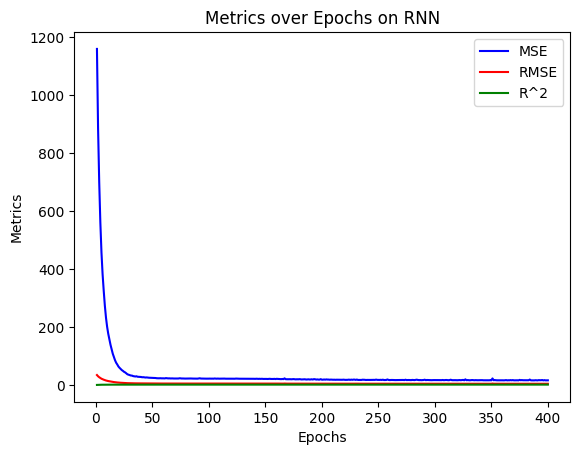

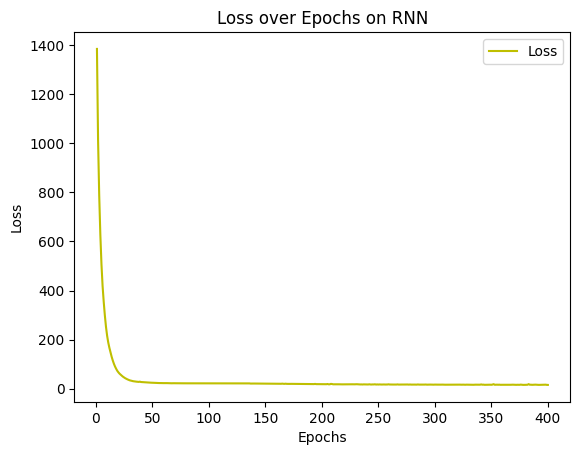

In [11]:
# Train RNN model
model_RNN = keras.Sequential()
model_RNN.add(keras.layers.SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_RNN.add(keras.layers.Dense(units=1))
model_RNN.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on RNN', 'Loss over Epochs on RNN'], ['./task2_data/output/RNN_metrics.png', './task2_data/output/RNN_loss.png'])
model_RNN.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=400, batch_size=256, callbacks=[metrics_history_callback])

In [12]:
# Save RNN model
model_RNN.save('./task2_data/output/RNN_model.keras')

In [13]:
# Predict values
Y_pred = model_RNN.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for RNN")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
Metric for RNN
MSE = 18.21743271222387
RMSE = 4.268188457908562
R^2 = 0.9837916878964772


Epoch 1/400


/home/choconao/Documents/Programming/Python/Neural Networks/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1659.9755 - val_loss: 1197.6478
Epoch 2/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1111.7262 - val_loss: 891.1190
Epoch 3/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 846.7364 - val_loss: 701.5616
Epoch 4/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 656.1564 - val_loss: 563.9657
Epoch 5/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 519.6723 - val_loss: 454.8637
Epoch 6/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 412.9276 - val_loss: 374.8738
Epoch 7/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 343.2629 - val_loss: 313.0118
Epoch 8/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━

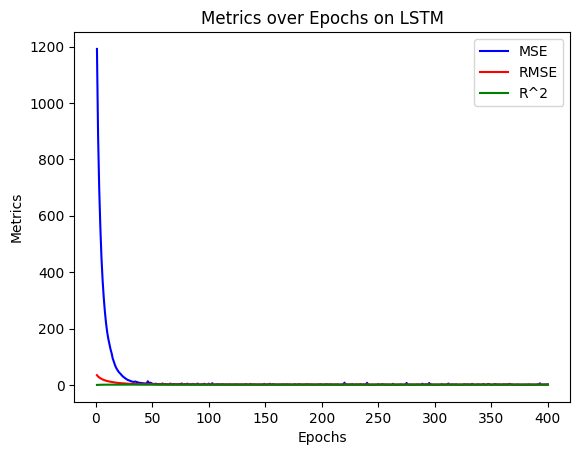

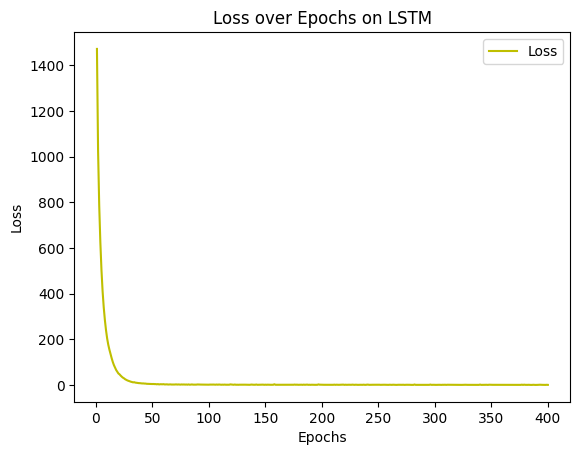

In [14]:
# Train LSTM model
model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_LSTM.add(keras.layers.Dense(units=1))
model_LSTM.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on LSTM', 'Loss over Epochs on LSTM'], ['./task2_data/output/LSTM_metrics.png', './task2_data/output/LSTM_loss.png'])
model_LSTM.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=400, batch_size=256, callbacks=[metrics_history_callback])

In [15]:
# Save LSTM model
model_LSTM.save('./task2_data/output/LSTM_model.keras')

In [16]:
Y_pred = model_LSTM.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for LSTM")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Metric for LSTM
MSE = 1.5377597431136216
RMSE = 1.240064410872928
R^2 = 0.9986318330222296


Epoch 1/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1547.9952 - val_loss: 1210.4808
Epoch 2/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1105.5153 - val_loss: 881.9505
Epoch 3/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 814.3573 - val_loss: 689.8412
Epoch 4/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 652.9133 - val_loss: 553.1332
Epoch 5/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 526.7000 - val_loss: 459.1494
Epoch 6/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 432.1803 - val_loss: 394.9148
Epoch 7/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 378.7402 - val_loss: 352.9190
Epoch 8/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step
110/110

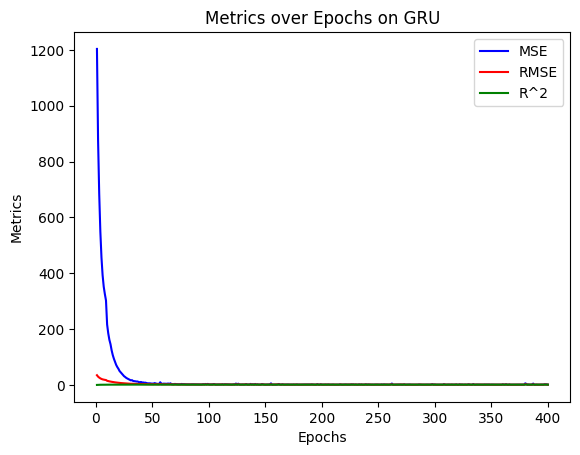

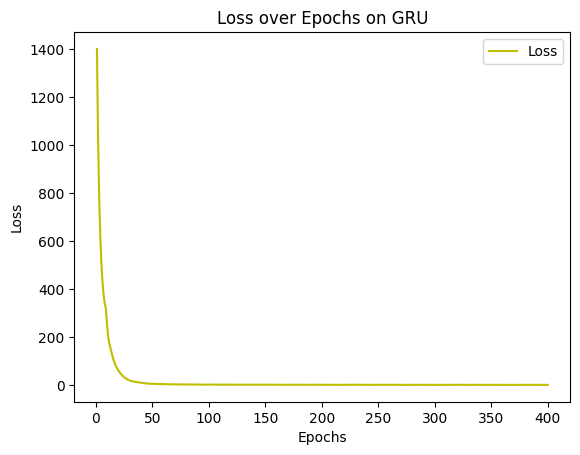

In [17]:
# Train GRU model
model_GRU = keras.Sequential()
model_GRU.add(keras.layers.GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_GRU.add(keras.layers.Dense(units=1))
model_GRU.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on GRU', 'Loss over Epochs on GRU'], ['./task2_data/output/GRU_metrics.png', './task2_data/output/GRU_loss.png'])
model_GRU.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=400, batch_size=256, callbacks=[metrics_history_callback])

In [18]:
# Save GRU model
model_GRU.save('./task2_data/output/GRU_model.keras')

In [19]:
Y_pred = model_GRU.predict(X_test)
mse, rmse, r_squared = calculate_metrics(Y_test, Y_pred)
print("Metric for GRU")
print("MSE = "+str(mse))
print("RMSE = "+str(rmse))
print("R^2 = "+str(r_squared))

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Metric for GRU
MSE = 0.9155517488929844
RMSE = 0.956844683787805
R^2 = 0.999185420430672


Epoch 1/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 1490.1790 - val_loss: 1247.1448
Epoch 2/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 1224.2808 - val_loss: 1161.8282
Epoch 3/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 1138.7014 - val_loss: 1132.7548
Epoch 4/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 1124.0164 - val_loss: 839.3721
Epoch 5/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 757.0945 - val_loss: 563.3720
Epoch 6/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 529.5203 - val_loss: 423.6646
Epoch 7/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 401.1151 - val_loss: 332.0710
Epoch 8/400
876/876 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
110/110 

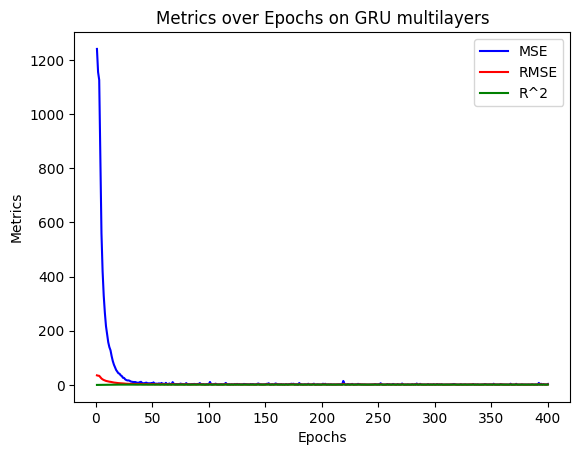

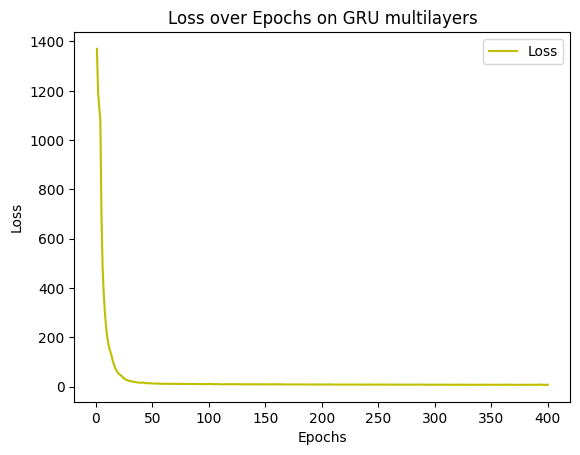

In [20]:
model_GRU_multilayers = keras.Sequential()
model_GRU_multilayers.add(keras.layers.GRU(units = 64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_GRU_multilayers.add(keras.layers.Dropout(0.2))
model_GRU_multilayers.add(keras.layers.GRU(units = 64,return_sequences=True))
model_GRU_multilayers.add(keras.layers.Dropout(0.2))
model_GRU_multilayers.add(keras.layers.GRU(units = 64,return_sequences=True))
model_GRU_multilayers.add(keras.layers.Dropout(0.2))
model_GRU_multilayers.add(keras.layers.GRU(units = 64))
model_GRU_multilayers.add(keras.layers.Dropout(0.2))
model_GRU_multilayers.add(keras.layers.Dense(units=1))
model_GRU_multilayers.compile(optimizer='adam', loss='mse')
metrics_history_callback = MetricsHistory(X_train, Y_train,['Metrics over Epochs on GRU multilayers', 'Loss over Epochs on GRU multilayers'], ['./task2_data/output/GRU_multilayer_metrics.png', './task2_data/output/GRU_multilayer_loss.png'])
model_GRU_multilayers.fit(X_train, Y_train,validation_data =(X_test, Y_test), epochs= 400, batch_size= 256, callbacks=[metrics_history_callback])